In [48]:
from cassandra.cluster import Cluster
import station_pb2_grpc
import station_pb2
import pandas as pd
import sys
import os
import subprocess
import grpc
from datetime import date

from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType,StringType
from pyspark.sql.functions import udf
from pyspark.sql.functions import corr
from pyspark.sql.functions import col

Part 1

In [49]:
try:
    cluster = Cluster(['p6_db_2', 'p6_db_1', 'p6_db_3'])
    session = cluster.connect()
except Exception as e:
    print(e)

Traceback (most recent call last):
  File "cassandra/cluster.py", line 3194, in cassandra.cluster.Session.add_or_renew_pool.run_add_or_renew_pool
  File "cassandra/pool.py", line 406, in cassandra.pool.HostConnection.__init__
  File "cassandra/cluster.py", line 1630, in cassandra.cluster.Cluster.connection_factory
  File "cassandra/connection.py", line 850, in cassandra.connection.Connection.factory
  File "/usr/local/lib/python3.10/dist-packages/cassandra/io/asyncorereactor.py", line 347, in __init__
    self._connect_socket()
  File "cassandra/connection.py", line 917, in cassandra.connection.Connection._connect_socket
ConnectionRefusedError: [Errno 111] Tried connecting to [('172.21.0.4', 9042)]. Last error: Connection refused


In [50]:
session.execute(" DROP KEYSPACE IF EXISTS weather;") # Ensure to drop the keyspace

# Create keyspace
session.execute("""CREATE KEYSPACE weather
  WITH REPLICATION = { 
   'class' : 'SimpleStrategy', 
   'replication_factor' : 3 
  };""")

# Create type
session.execute(""" CREATE type weather.station_record (
    tmin int,
    tmax int                
);""")

# Create table
session.execute(""" CREATE TABLE weather.stations (
    id text,
    name text STATIC,
    date date,
    record FROZEN<weather.station_record>,
    PRIMARY KEY (id, date)              
) WITH CLUSTERING ORDER BY (date ASC); """)

In [51]:
print(session.execute("describe keyspace weather").one().create_statement)
print(session.execute("describe table weather.stations").one().create_statement)

CREATE KEYSPACE weather WITH replication = {'class': 'SimpleStrategy', 'replication_factor': '3'}  AND durable_writes = true;
CREATE TABLE weather.stations (
    id text,
    date date,
    name text static,
    record frozen<station_record>,
    PRIMARY KEY (id, date)
) WITH CLUSTERING ORDER BY (date ASC)
    AND additional_write_policy = '99p'
    AND bloom_filter_fp_chance = 0.01
    AND caching = {'keys': 'ALL', 'rows_per_partition': 'NONE'}
    AND cdc = false
    AND comment = ''
    AND compaction = {'class': 'org.apache.cassandra.db.compaction.SizeTieredCompactionStrategy', 'max_threshold': '32', 'min_threshold': '4'}
    AND compression = {'chunk_length_in_kb': '16', 'class': 'org.apache.cassandra.io.compress.LZ4Compressor'}
    AND crc_check_chance = 1.0
    AND default_time_to_live = 0
    AND extensions = {}
    AND gc_grace_seconds = 864000
    AND max_index_interval = 2048
    AND memtable_flush_period_in_ms = 0
    AND min_index_interval = 128
    AND read_repair = 'BLOC

In [25]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("p6")
         .config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.2.0')
         .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions")
         .getOrCreate())

In [9]:
if not os.path.exists("ghcnd-stations.txt"):
    ! wget https://pages.cs.wisc.edu/~harter/cs544/data/ghcnd-stations.txt

--2023-08-31 17:21:55--  https://pages.cs.wisc.edu/~harter/cs544/data/ghcnd-stations.txt
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10607756 (10M) [text/plain]
Saving to: ‘ghcnd-stations.txt’

ghcnd-stations.txt  100%[===================>]  10.12M  13.3MB/s    in 0.8s    

2023-08-31 17:21:56 (13.3 MB/s) - ‘ghcnd-stations.txt’ saved [10607756/10607756]



In [10]:
df = spark.read.text("ghcnd-stations.txt").toPandas()
df.head()

,value
0,ACW00011604 17.1167 -61.7833 10.1 ST JO...
1,ACW00011647 17.1333 -61.7833 19.2 ST JO...
2,AE000041196 25.3330 55.5170 34.0 SHARJ...
3,AEM00041194 25.2550 55.3640 10.4 DUBAI...
4,AEM00041217 24.4330 54.6510 26.8 ABU D...


In [11]:
col_ranges = {
    "ID" : [1, 11],
    "LATITUDE" : [13, 20],
    "LONGITUDE" : [22, 30],
    "ELEVATION" : [32, 37],
    "STATE" : [39, 40],
    "NAME" : [42, 71],
    "GSN FLAG" : [73, 75],
    "HCN/CRN FLAG" : [77, 79],
    "WMO ID" : [81, 85]
}

for col_name in col_ranges:
    range_vals = col_ranges[col_name]
    start_val, end_val = range_vals[0], range_vals[1]
    df[col_name] = df["value"].str[start_val - 1 : end_val]
    df[col_name] = df[col_name].str.strip()

wisconsin_data = df[df["STATE"] == "WI"]
print("Number of data points is", len(wisconsin_data.index))
wisconsin_data.head()

Number of data points is 1313


,value,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
93901,US1WIAD0002 43.9544 -89.8096 294.4 WI ADAMS...,US1WIAD0002,43.9544,-89.8096,294.4,WI,ADAMS 0.4 E,,,
93902,US1WIAD0005 44.2053 -89.8480 305.7 WI NEKOO...,US1WIAD0005,44.2053,-89.8480,305.7,WI,NEKOOSA 8.0 SSE,,,
93903,US1WIAD0006 43.8858 -89.7259 307.8 WI GRAND...,US1WIAD0006,43.8858,-89.7259,307.8,WI,GRAND MARSH 1.0 W,,,
93904,US1WIAD0008 43.8611 -89.7163 310.0 WI GRAND...,US1WIAD0008,43.8611,-89.7163,310.0,WI,GRAND MARSH 1.9 SSW,,,
93905,US1WIAD0010 43.7864 -89.6417 293.8 WI OXFOR...,US1WIAD0010,43.7864,-89.6417,293.8,WI,OXFORD 4.0 W,,,


In [12]:
query = "INSERT INTO weather.stations(id, name) VALUES (?, ?)"
prepared = session.prepare(query)
for index, row in df.iterrows():
    session.execute(prepared, (row["ID"], row["NAME"]) )

# Verify that the rows were inserted properly
rows = session.execute("SELECT id, name FROM weather.stations LIMIT 5")
print(rows[0])

Row(id='US1AZPM0036', name='TUCSON 3.9 NW')


/tmp/ipykernel_511/4276896248.py:8: DeprecationWarning: ResultSet indexing support will be removed in 4.0. Consider using ResultSet.one() to get a single row.
  print(rows[0])


In [19]:
# Get the row token
row = session.execute("SELECT token(id) FROM weather.stations WHERE id = %s", ("USC00470273",))
row_token = row.one()[0]

# Get all the vnode tokens
result = subprocess.check_output(["nodetool", "ring"]).decode(sys.stdout.encoding)
lines = result.splitlines()[3 : ]
token_idx = lines.pop(0).index("Token")
lines.pop(0)
tokens = [line[token_idx : ].strip() for line in lines]

# Get the v node token
vnode_token = None
for i in range(0, len(tokens) - 1):
    # Check if the row is in this range
    if row_token >= int(tokens[i]) and row_token <= int(tokens[i + 1]):
        vnode_token = tokens[i + 1]
        break

In [20]:
print("row token:", row_token)
print("vnode token:", vnode_token)

row token: -9014250178872933741
vnode token: -8607065288305587308


Part 2

In [25]:
if not os.path.exists("wi-stations.zip"):
    !wget https://pages.cs.wisc.edu/~harter/cs544/data/wi-stations.zip
    !unzip wi-stations.zip

--2023-08-31 17:31:20--  https://pages.cs.wisc.edu/~harter/cs544/data/wi-stations.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133113222 (127M) [application/zip]
Saving to: ‘wi-stations.zip’

wi-stations.zip     100%[===================>] 126.95M  16.7MB/s    in 7.9s    

2023-08-31 17:31:28 (16.1 MB/s) - ‘wi-stations.zip’ saved [133113222/133113222]

Archive:  wi-stations.zip
  inflating: US1WIAD0002.csv.gz      
  inflating: US1WIAD0005.csv.gz      
  inflating: US1WIAD0006.csv.gz      
  inflating: US1WIAD0008.csv.gz      
  inflating: US1WIAD0010.csv.gz      
 extracting: US1WIAD0015.csv.gz      
  inflating: US1WIAD0016.csv.gz      
  inflating: US1WIAD0017.csv.gz      
 extracting: US1WIAS0003.csv.gz      
  inflating: US1WIAS0004.csv.gz      
  inflating: US1WIAS0006.csv.gz      
  inflating: US1WIAS0011.csv.gz      
 ext

In [6]:
PORT_TO_USE = 5440
SERVER_ADDRESS = f"127.0.0.1:{PORT_TO_USE}"

channel = grpc.insecure_channel(SERVER_ADDRESS)
stub = station_pb2_grpc.StationStub(channel)

In [52]:
def simulate_sensor(station):
    col_names = ["station_id", "date", "type", "value", "Unknown#1", "Unknown#2", "Unknown#3", "Unknown#4"]
    df = pd.read_csv(station + ".csv.gz", names = col_names, header = None)

    record_by_date = {}
    for index, row in df.iterrows():
        # Make sure they are 2022 records
        record_date = str(row["date"]).strip()

        if record_date[ : 4] != "2022":
            continue
        
        # Make sure they are temperature records
        if row["type"] != "TMAX" and row["type"] != "TMIN":
            continue
        
        date_val = date(int(record_date[ : 4]), int(record_date[4 : 6]), int(record_date[6 : ]))
        if date_val not in record_by_date:
            record_by_date[date_val] = []
        record_by_date[date_val].append(int(row["value"]))
    
    for curr_date in record_by_date:
        date_temps = record_by_date[curr_date]
        response = stub.RecordTemps(station_pb2.RecordTempsRequest(station = station, date = str(curr_date), tmin = min(date_temps), tmax = max(date_temps)))

In [53]:
for station in ["USW00014837", "USR0000WDDG", "USW00014898", "USW00014839"]:
    simulate_sensor(station)
    r = stub.StationMax(station_pb2.StationMaxRequest(station=station))
    if r.error:
        print(r.error)
    else:
        print(f"max temp for {station} is {r.tmax}")

/tmp/ipykernel_349/2591731489.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(station + ".csv.gz", names = col_names, header = None)


max temp for USW00014837 is 356
max temp for USR0000WDDG is 344


/tmp/ipykernel_349/2591731489.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(station + ".csv.gz", names = col_names, header = None)


max temp for USW00014898 is 356


/tmp/ipykernel_349/2591731489.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(station + ".csv.gz", names = col_names, header = None)


max temp for USW00014839 is 378


Part 3

In [46]:
# Create Spark DF
query = f"SELECT * FROM weather.stations"
results = session.execute(query)
df_rows = []
for row in results:
    df_rows.append([row.id, str(row.date), row.record.tmin,  row.record.tmax])

pandas_df = pd.DataFrame(df_rows, columns = ["id", "date", "tmin", "tmax"])
pandas_df.iteritems = pandas_df.items
spark_df = spark.createDataFrame(pandas_df)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/types.py:284: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


In [47]:
print("Original number of items is", len(pandas_df.index))

Original number of items is 1825


In [37]:
# Create a cached view
spark_df = spark_df.filter(col("date").contains("2022"))
spark_df.createOrReplaceTempView("weather2022")
spark.catalog.cacheTable("weather2022")

In [38]:
def celsius_to_farehneith(temp):
    return float((0.1 * temp) * 9.0/5.0 + 32.0)

temp_udf = udf(lambda t : celsius_to_farehneith(t))
spark.udf.register("temp_convert_udf", temp_udf)

spark.sql("show tables").show()

+---------+-----------+-----------+
|namespace|  tableName|isTemporary|
+---------+-----------+-----------+
|         |weather2022|       true|
+---------+-----------+-----------+



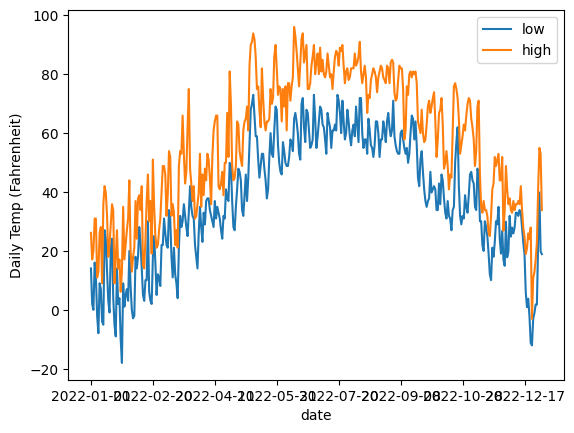

In [40]:
data = spark.sql("""
SELECT id, date, temp_convert_udf(tmin) as min_temp, temp_convert_udf(tmax) as max_temp
FROM weather2022
WHERE id = "USW00014837"
""").toPandas()

data["min_temp"]= data['min_temp'].astype(float)
data['max_temp'] = data['max_temp'].astype(float)

fig = data.plot.line(x = "date", y = ["min_temp", "max_temp"], ylabel = "Daily Temp (Fahrenheit)")
fig.legend(["low", "high"])

In [42]:
df1 = spark.sql("""
SELECT id, temp_convert_udf(tmax) as temp_max
FROM weather2022
WHERE id = "USW00014837" 
""").toPandas()

df2 = spark.sql("""
SELECT id, temp_convert_udf(tmax) as temp_max
FROM weather2022
WHERE id = "USW00014839"
""").toPandas()

df3 = spark.createDataFrame(zip(df1["temp_max"], df2["temp_max"]), ["df", "df2"])
df3.agg(corr("df", "df2").alias("corr")).collect()

[Row(corr=0.9786907979650679)]

Part 4

In [55]:
pre_refersh_count = session.execute("SELECT COUNT(*) FROM weather.stations")
print("Pre count is", pre_refersh_count.one())

Pre count is Row(count=1460)


In [56]:
stub.StationMax(station_pb2.StationMaxRequest(station="USW00014837"))

tmax: -1
error: "Couldn\'t find max value for station USW00014837"

In [57]:
simulate_sensor("USC00477115")

In [60]:
post_referesh_count = session.execute("SELECT COUNT(*) FROM weather.stations")
print("Post count is", post_referesh_count.one())

Post count is Row(count=1825)


Apache Spark Erorr Show Case

In [70]:
# Start code from the project
try:
    cluster = Cluster(['p6_db_2', 'p6_db_1', 'p6_db_3'])
    session = cluster.connect()
except Exception as e:
    print(e)

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("p5")
         .config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.2.0') #3.3.0 update
         .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions")
         .getOrCreate())

In [73]:
from pyspark.sql.types import IntegerType,StringType
from pyspark.sql.functions import udf
from pyspark.sql.functions import corr

# Code from Lecture 25
spark.conf.set("spark.sql.catalog.cassandra", "com.datastax.spark.connector.datasource.CassandraCatalog")
spark.conf.set("spark.sql.catalog.cassandra.spark.cassandra.connection.host", "p6_db_1:9042")
stations = spark.table("cassandra.weather.stations")

23/08/31 19:23:44 WARN ControlConnection: [s2] Error connecting to Node(endPoint=/127.0.0.1:9042, hostId=null, hashCode=5bac7614), trying next node (ConnectionInitException: [s2|control|connecting...] Protocol initialization request, step 1 (OPTIONS): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException))


Py4JJavaError: An error occurred while calling o29.table.
: java.io.IOException: Failed to open native connection to Cassandra at {} :: Could not reach any contact point, make sure you've provided valid addresses (showing first 1 nodes, use getAllErrors() for more): Node(endPoint=/127.0.0.1:9042, hostId=null, hashCode=5bac7614): [com.datastax.oss.driver.api.core.connection.ConnectionInitException: [s2|control|connecting...] Protocol initialization request, step 1 (OPTIONS): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException)]
	at com.datastax.spark.connector.cql.CassandraConnector$.createSession(CassandraConnector.scala:173)
	at com.datastax.spark.connector.cql.CassandraConnector$.$anonfun$sessionCache$1(CassandraConnector.scala:161)
	at com.datastax.spark.connector.cql.RefCountedCache.createNewValueAndKeys(RefCountedCache.scala:32)
	at com.datastax.spark.connector.cql.RefCountedCache.syncAcquire(RefCountedCache.scala:69)
	at com.datastax.spark.connector.cql.RefCountedCache.acquire(RefCountedCache.scala:57)
	at com.datastax.spark.connector.cql.CassandraConnector.openSession(CassandraConnector.scala:81)
	at com.datastax.spark.connector.cql.CassandraConnector.withSessionDo(CassandraConnector.scala:103)
	at com.datastax.spark.connector.datasource.CassandraCatalog$.com$datastax$spark$connector$datasource$CassandraCatalog$$getMetadata(CassandraCatalog.scala:455)
	at com.datastax.spark.connector.datasource.CassandraCatalog$.getTableMetaData(CassandraCatalog.scala:421)
	at com.datastax.spark.connector.datasource.CassandraCatalog.loadTable(CassandraCatalog.scala:210)
	at org.apache.spark.sql.connector.catalog.CatalogV2Util$.loadTable(CatalogV2Util.scala:281)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveTables$.org$apache$spark$sql$catalyst$analysis$Analyzer$ResolveTables$$lookupV2Relation(Analyzer.scala:1112)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveTables$$anonfun$apply$14.applyOrElse(Analyzer.scala:1062)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveTables$$anonfun$apply$14.applyOrElse(Analyzer.scala:1060)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$3(AnalysisHelper.scala:138)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:82)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:138)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:323)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:134)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:130)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveTables$.apply(Analyzer.scala:1060)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveTables$.apply(Analyzer.scala:1058)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:211)
	at scala.collection.LinearSeqOptimized.foldLeft(LinearSeqOptimized.scala:126)
	at scala.collection.LinearSeqOptimized.foldLeft$(LinearSeqOptimized.scala:122)
	at scala.collection.immutable.List.foldLeft(List.scala:91)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:208)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:200)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:200)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:222)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:218)
	at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:167)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:218)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:182)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:179)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:88)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:179)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:203)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:330)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:202)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$analyzed$1(QueryExecution.scala:75)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:111)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:183)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:183)
	at org.apache.spark.sql.execution.QueryExecution.analyzed$lzycompute(QueryExecution.scala:75)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:73)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:65)
	at org.apache.spark.sql.Dataset$.$anonfun$ofRows$1(Dataset.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:88)
	at org.apache.spark.sql.DataFrameReader.table(DataFrameReader.scala:641)
	at org.apache.spark.sql.SparkSession.table(SparkSession.scala:596)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: com.datastax.oss.driver.api.core.AllNodesFailedException: Could not reach any contact point, make sure you've provided valid addresses (showing first 1 nodes, use getAllErrors() for more): Node(endPoint=/127.0.0.1:9042, hostId=null, hashCode=5bac7614): [com.datastax.oss.driver.api.core.connection.ConnectionInitException: [s2|control|connecting...] Protocol initialization request, step 1 (OPTIONS): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException)]
	at com.datastax.oss.driver.api.core.AllNodesFailedException.copy(AllNodesFailedException.java:141)
	at com.datastax.oss.driver.internal.core.util.concurrent.CompletableFutures.getUninterruptibly(CompletableFutures.java:149)
	at com.datastax.oss.driver.api.core.session.SessionBuilder.build(SessionBuilder.java:835)
	at com.datastax.spark.connector.cql.DefaultConnectionFactory$.createSession(CassandraConnectionFactory.scala:143)
	at com.datastax.spark.connector.cql.CassandraConnector$.createSession(CassandraConnector.scala:167)
	... 66 more
	Suppressed: com.datastax.oss.driver.api.core.connection.ConnectionInitException: [s2|control|connecting...] Protocol initialization request, step 1 (OPTIONS): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException)
		at com.datastax.oss.driver.internal.core.channel.ProtocolInitHandler$InitRequest.fail(ProtocolInitHandler.java:356)
		at com.datastax.oss.driver.internal.core.channel.ChannelHandlerRequest.writeListener(ChannelHandlerRequest.java:87)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListener0(DefaultPromise.java:578)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListenersNow(DefaultPromise.java:552)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListeners(DefaultPromise.java:491)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.addListener(DefaultPromise.java:184)
		at com.datastax.oss.driver.shaded.netty.channel.DefaultChannelPromise.addListener(DefaultChannelPromise.java:95)
		at com.datastax.oss.driver.shaded.netty.channel.DefaultChannelPromise.addListener(DefaultChannelPromise.java:30)
		at com.datastax.oss.driver.internal.core.channel.ChannelHandlerRequest.send(ChannelHandlerRequest.java:76)
		at com.datastax.oss.driver.internal.core.channel.ProtocolInitHandler$InitRequest.send(ProtocolInitHandler.java:193)
		at com.datastax.oss.driver.internal.core.channel.ProtocolInitHandler.onRealConnect(ProtocolInitHandler.java:124)
		at com.datastax.oss.driver.internal.core.channel.ConnectInitHandler.lambda$connect$0(ConnectInitHandler.java:57)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListener0(DefaultPromise.java:578)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListeners0(DefaultPromise.java:571)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListenersNow(DefaultPromise.java:550)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListeners(DefaultPromise.java:491)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.setValue0(DefaultPromise.java:616)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.setFailure0(DefaultPromise.java:609)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.tryFailure(DefaultPromise.java:117)
		at com.datastax.oss.driver.shaded.netty.channel.nio.AbstractNioChannel$AbstractNioUnsafe.fulfillConnectPromise(AbstractNioChannel.java:321)
		at com.datastax.oss.driver.shaded.netty.channel.nio.AbstractNioChannel$AbstractNioUnsafe.finishConnect(AbstractNioChannel.java:337)
		at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:707)
		at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:655)
		at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:581)
		at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989)
		at com.datastax.oss.driver.shaded.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30)
		... 1 more
		Suppressed: com.datastax.oss.driver.shaded.netty.channel.AbstractChannel$AnnotatedConnectException: Connection refused: /127.0.0.1:9042
		Caused by: java.net.ConnectException: Connection refused
			at sun.nio.ch.SocketChannelImpl.checkConnect(Native Method)
			at sun.nio.ch.SocketChannelImpl.finishConnect(SocketChannelImpl.java:716)
			at com.datastax.oss.driver.shaded.netty.channel.socket.nio.NioSocketChannel.doFinishConnect(NioSocketChannel.java:330)
			at com.datastax.oss.driver.shaded.netty.channel.nio.AbstractNioChannel$AbstractNioUnsafe.finishConnect(AbstractNioChannel.java:334)
			at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:707)
			at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:655)
			at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:581)
			at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493)
			at com.datastax.oss.driver.shaded.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989)
			at com.datastax.oss.driver.shaded.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74)
			at com.datastax.oss.driver.shaded.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30)
			at java.lang.Thread.run(Thread.java:750)
	Caused by: com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException
		at com.datastax.oss.driver.shaded.netty.channel.AbstractChannel$AbstractUnsafe.flush0()(Unknown Source)


In [75]:
!cqlsh

Connection error: ('Unable to connect to any servers', {'127.0.0.1:9042': ConnectionRefusedError(111, "Tried connecting to [('127.0.0.1', 9042)]. Last error: Connection refused")})


In [82]:
!netstat -tuln | grep 9042

tcp        0      0 172.21.0.2:9042         0.0.0.0:*               LISTEN     


In [83]:
!cqlsh 172.21.0.2 9042

Connected to Test Cluster at 172.21.0.2:9042
[cqlsh 6.0.0 | Cassandra 4.0.7 | CQL spec 3.4.5 | Native protocol v5]
Use HELP for help.
cqlsh> 

cqlsh> 

This indicates that error occurs because Spark is trying to connect to "127.0.0.1:9042" but it is actually being hosted on "172.21.0.2 9042". However, updating the connection endpoint config doesn't change this at all

In [85]:
spark.conf.set("spark.sql.catalog.cassandra", "com.datastax.spark.connector.datasource.CassandraCatalog")
spark.conf.set("spark.sql.catalog.cassandra.spark.cassandra.connection.host", "172.21.0.2:9042")
stations = spark.table("cassandra.weather.stations")

23/08/31 19:37:34 WARN ControlConnection: [s3] Error connecting to Node(endPoint=/127.0.0.1:9042, hostId=null, hashCode=5361b3f2), trying next node (ConnectionInitException: [s3|control|connecting...] Protocol initialization request, step 1 (OPTIONS): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException))


Py4JJavaError: An error occurred while calling o29.table.
: java.io.IOException: Failed to open native connection to Cassandra at {} :: Could not reach any contact point, make sure you've provided valid addresses (showing first 1 nodes, use getAllErrors() for more): Node(endPoint=/127.0.0.1:9042, hostId=null, hashCode=5361b3f2): [com.datastax.oss.driver.api.core.connection.ConnectionInitException: [s3|control|connecting...] Protocol initialization request, step 1 (OPTIONS): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException)]
	at com.datastax.spark.connector.cql.CassandraConnector$.createSession(CassandraConnector.scala:173)
	at com.datastax.spark.connector.cql.CassandraConnector$.$anonfun$sessionCache$1(CassandraConnector.scala:161)
	at com.datastax.spark.connector.cql.RefCountedCache.createNewValueAndKeys(RefCountedCache.scala:32)
	at com.datastax.spark.connector.cql.RefCountedCache.syncAcquire(RefCountedCache.scala:69)
	at com.datastax.spark.connector.cql.RefCountedCache.acquire(RefCountedCache.scala:57)
	at com.datastax.spark.connector.cql.CassandraConnector.openSession(CassandraConnector.scala:81)
	at com.datastax.spark.connector.cql.CassandraConnector.withSessionDo(CassandraConnector.scala:103)
	at com.datastax.spark.connector.datasource.CassandraCatalog$.com$datastax$spark$connector$datasource$CassandraCatalog$$getMetadata(CassandraCatalog.scala:455)
	at com.datastax.spark.connector.datasource.CassandraCatalog$.getTableMetaData(CassandraCatalog.scala:421)
	at com.datastax.spark.connector.datasource.CassandraCatalog.loadTable(CassandraCatalog.scala:210)
	at org.apache.spark.sql.connector.catalog.CatalogV2Util$.loadTable(CatalogV2Util.scala:281)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveTables$.org$apache$spark$sql$catalyst$analysis$Analyzer$ResolveTables$$lookupV2Relation(Analyzer.scala:1112)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveTables$$anonfun$apply$14.applyOrElse(Analyzer.scala:1062)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveTables$$anonfun$apply$14.applyOrElse(Analyzer.scala:1060)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$3(AnalysisHelper.scala:138)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:82)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:138)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:323)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:134)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:130)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveTables$.apply(Analyzer.scala:1060)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveTables$.apply(Analyzer.scala:1058)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:211)
	at scala.collection.LinearSeqOptimized.foldLeft(LinearSeqOptimized.scala:126)
	at scala.collection.LinearSeqOptimized.foldLeft$(LinearSeqOptimized.scala:122)
	at scala.collection.immutable.List.foldLeft(List.scala:91)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:208)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:200)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:200)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:222)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:218)
	at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:167)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:218)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:182)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:179)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:88)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:179)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:203)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:330)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:202)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$analyzed$1(QueryExecution.scala:75)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:111)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:183)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:183)
	at org.apache.spark.sql.execution.QueryExecution.analyzed$lzycompute(QueryExecution.scala:75)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:73)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:65)
	at org.apache.spark.sql.Dataset$.$anonfun$ofRows$1(Dataset.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:88)
	at org.apache.spark.sql.DataFrameReader.table(DataFrameReader.scala:641)
	at org.apache.spark.sql.SparkSession.table(SparkSession.scala:596)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: com.datastax.oss.driver.api.core.AllNodesFailedException: Could not reach any contact point, make sure you've provided valid addresses (showing first 1 nodes, use getAllErrors() for more): Node(endPoint=/127.0.0.1:9042, hostId=null, hashCode=5361b3f2): [com.datastax.oss.driver.api.core.connection.ConnectionInitException: [s3|control|connecting...] Protocol initialization request, step 1 (OPTIONS): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException)]
	at com.datastax.oss.driver.api.core.AllNodesFailedException.copy(AllNodesFailedException.java:141)
	at com.datastax.oss.driver.internal.core.util.concurrent.CompletableFutures.getUninterruptibly(CompletableFutures.java:149)
	at com.datastax.oss.driver.api.core.session.SessionBuilder.build(SessionBuilder.java:835)
	at com.datastax.spark.connector.cql.DefaultConnectionFactory$.createSession(CassandraConnectionFactory.scala:143)
	at com.datastax.spark.connector.cql.CassandraConnector$.createSession(CassandraConnector.scala:167)
	... 66 more
	Suppressed: com.datastax.oss.driver.api.core.connection.ConnectionInitException: [s3|control|connecting...] Protocol initialization request, step 1 (OPTIONS): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException)
		at com.datastax.oss.driver.internal.core.channel.ProtocolInitHandler$InitRequest.fail(ProtocolInitHandler.java:356)
		at com.datastax.oss.driver.internal.core.channel.ChannelHandlerRequest.writeListener(ChannelHandlerRequest.java:87)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListener0(DefaultPromise.java:578)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListenersNow(DefaultPromise.java:552)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListeners(DefaultPromise.java:491)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.addListener(DefaultPromise.java:184)
		at com.datastax.oss.driver.shaded.netty.channel.DefaultChannelPromise.addListener(DefaultChannelPromise.java:95)
		at com.datastax.oss.driver.shaded.netty.channel.DefaultChannelPromise.addListener(DefaultChannelPromise.java:30)
		at com.datastax.oss.driver.internal.core.channel.ChannelHandlerRequest.send(ChannelHandlerRequest.java:76)
		at com.datastax.oss.driver.internal.core.channel.ProtocolInitHandler$InitRequest.send(ProtocolInitHandler.java:193)
		at com.datastax.oss.driver.internal.core.channel.ProtocolInitHandler.onRealConnect(ProtocolInitHandler.java:124)
		at com.datastax.oss.driver.internal.core.channel.ConnectInitHandler.lambda$connect$0(ConnectInitHandler.java:57)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListener0(DefaultPromise.java:578)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListeners0(DefaultPromise.java:571)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListenersNow(DefaultPromise.java:550)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListeners(DefaultPromise.java:491)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.setValue0(DefaultPromise.java:616)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.setFailure0(DefaultPromise.java:609)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.tryFailure(DefaultPromise.java:117)
		at com.datastax.oss.driver.shaded.netty.channel.nio.AbstractNioChannel$AbstractNioUnsafe.fulfillConnectPromise(AbstractNioChannel.java:321)
		at com.datastax.oss.driver.shaded.netty.channel.nio.AbstractNioChannel$AbstractNioUnsafe.finishConnect(AbstractNioChannel.java:337)
		at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:707)
		at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:655)
		at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:581)
		at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989)
		at com.datastax.oss.driver.shaded.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30)
		... 1 more
		Suppressed: com.datastax.oss.driver.shaded.netty.channel.AbstractChannel$AnnotatedConnectException: Connection refused: /127.0.0.1:9042
		Caused by: java.net.ConnectException: Connection refused
			at sun.nio.ch.SocketChannelImpl.checkConnect(Native Method)
			at sun.nio.ch.SocketChannelImpl.finishConnect(SocketChannelImpl.java:716)
			at com.datastax.oss.driver.shaded.netty.channel.socket.nio.NioSocketChannel.doFinishConnect(NioSocketChannel.java:330)
			at com.datastax.oss.driver.shaded.netty.channel.nio.AbstractNioChannel$AbstractNioUnsafe.finishConnect(AbstractNioChannel.java:334)
			at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:707)
			at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:655)
			at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:581)
			at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493)
			at com.datastax.oss.driver.shaded.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989)
			at com.datastax.oss.driver.shaded.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74)
			at com.datastax.oss.driver.shaded.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30)
			at java.lang.Thread.run(Thread.java:750)
	Caused by: com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException
		at com.datastax.oss.driver.shaded.netty.channel.AbstractChannel$AbstractUnsafe.flush0()(Unknown Source)


In [88]:
# Even rebuilding doesn't help
spark = (SparkSession.builder
         .appName("p5")
         .config("spark.cassandra.connection.host", "172.21.0.2:9042")
         .config("spark.sql.catalog.cassandra.spark.cassandra.connection.host", "172.21.0.2:9042")
         .config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.2.0') #3.3.0 update
         .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions")
         .getOrCreate())

spark.conf.set("spark.sql.catalog.cassandra", "com.datastax.spark.connector.datasource.CassandraCatalog")
stations = spark.table("cassandra.weather.stations")

23/08/31 19:40:36 WARN ControlConnection: [s5] Error connecting to Node(endPoint=/127.0.0.1:9042, hostId=null, hashCode=1cee18b1), trying next node (ConnectionInitException: [s5|control|connecting...] Protocol initialization request, step 1 (OPTIONS): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException))


Py4JJavaError: An error occurred while calling o29.table.
: java.io.IOException: Failed to open native connection to Cassandra at {} :: Could not reach any contact point, make sure you've provided valid addresses (showing first 1 nodes, use getAllErrors() for more): Node(endPoint=/127.0.0.1:9042, hostId=null, hashCode=1cee18b1): [com.datastax.oss.driver.api.core.connection.ConnectionInitException: [s5|control|connecting...] Protocol initialization request, step 1 (OPTIONS): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException)]
	at com.datastax.spark.connector.cql.CassandraConnector$.createSession(CassandraConnector.scala:173)
	at com.datastax.spark.connector.cql.CassandraConnector$.$anonfun$sessionCache$1(CassandraConnector.scala:161)
	at com.datastax.spark.connector.cql.RefCountedCache.createNewValueAndKeys(RefCountedCache.scala:32)
	at com.datastax.spark.connector.cql.RefCountedCache.syncAcquire(RefCountedCache.scala:69)
	at com.datastax.spark.connector.cql.RefCountedCache.acquire(RefCountedCache.scala:57)
	at com.datastax.spark.connector.cql.CassandraConnector.openSession(CassandraConnector.scala:81)
	at com.datastax.spark.connector.cql.CassandraConnector.withSessionDo(CassandraConnector.scala:103)
	at com.datastax.spark.connector.datasource.CassandraCatalog$.com$datastax$spark$connector$datasource$CassandraCatalog$$getMetadata(CassandraCatalog.scala:455)
	at com.datastax.spark.connector.datasource.CassandraCatalog$.getTableMetaData(CassandraCatalog.scala:421)
	at com.datastax.spark.connector.datasource.CassandraCatalog.loadTable(CassandraCatalog.scala:210)
	at org.apache.spark.sql.connector.catalog.CatalogV2Util$.loadTable(CatalogV2Util.scala:281)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveTables$.org$apache$spark$sql$catalyst$analysis$Analyzer$ResolveTables$$lookupV2Relation(Analyzer.scala:1112)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveTables$$anonfun$apply$14.applyOrElse(Analyzer.scala:1062)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveTables$$anonfun$apply$14.applyOrElse(Analyzer.scala:1060)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$3(AnalysisHelper.scala:138)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:82)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:138)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:323)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:134)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:130)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveTables$.apply(Analyzer.scala:1060)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveTables$.apply(Analyzer.scala:1058)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:211)
	at scala.collection.LinearSeqOptimized.foldLeft(LinearSeqOptimized.scala:126)
	at scala.collection.LinearSeqOptimized.foldLeft$(LinearSeqOptimized.scala:122)
	at scala.collection.immutable.List.foldLeft(List.scala:91)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:208)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:200)
	at scala.collection.immutable.List.foreach(List.scala:431)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:200)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:222)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:218)
	at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:167)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:218)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:182)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:179)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:88)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:179)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:203)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:330)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:202)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$analyzed$1(QueryExecution.scala:75)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:111)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:183)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:183)
	at org.apache.spark.sql.execution.QueryExecution.analyzed$lzycompute(QueryExecution.scala:75)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:73)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:65)
	at org.apache.spark.sql.Dataset$.$anonfun$ofRows$1(Dataset.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:88)
	at org.apache.spark.sql.DataFrameReader.table(DataFrameReader.scala:641)
	at org.apache.spark.sql.SparkSession.table(SparkSession.scala:596)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: com.datastax.oss.driver.api.core.AllNodesFailedException: Could not reach any contact point, make sure you've provided valid addresses (showing first 1 nodes, use getAllErrors() for more): Node(endPoint=/127.0.0.1:9042, hostId=null, hashCode=1cee18b1): [com.datastax.oss.driver.api.core.connection.ConnectionInitException: [s5|control|connecting...] Protocol initialization request, step 1 (OPTIONS): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException)]
	at com.datastax.oss.driver.api.core.AllNodesFailedException.copy(AllNodesFailedException.java:141)
	at com.datastax.oss.driver.internal.core.util.concurrent.CompletableFutures.getUninterruptibly(CompletableFutures.java:149)
	at com.datastax.oss.driver.api.core.session.SessionBuilder.build(SessionBuilder.java:835)
	at com.datastax.spark.connector.cql.DefaultConnectionFactory$.createSession(CassandraConnectionFactory.scala:143)
	at com.datastax.spark.connector.cql.CassandraConnector$.createSession(CassandraConnector.scala:167)
	... 66 more
	Suppressed: com.datastax.oss.driver.api.core.connection.ConnectionInitException: [s5|control|connecting...] Protocol initialization request, step 1 (OPTIONS): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException)
		at com.datastax.oss.driver.internal.core.channel.ProtocolInitHandler$InitRequest.fail(ProtocolInitHandler.java:356)
		at com.datastax.oss.driver.internal.core.channel.ChannelHandlerRequest.writeListener(ChannelHandlerRequest.java:87)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListener0(DefaultPromise.java:578)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListenersNow(DefaultPromise.java:552)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListeners(DefaultPromise.java:491)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.addListener(DefaultPromise.java:184)
		at com.datastax.oss.driver.shaded.netty.channel.DefaultChannelPromise.addListener(DefaultChannelPromise.java:95)
		at com.datastax.oss.driver.shaded.netty.channel.DefaultChannelPromise.addListener(DefaultChannelPromise.java:30)
		at com.datastax.oss.driver.internal.core.channel.ChannelHandlerRequest.send(ChannelHandlerRequest.java:76)
		at com.datastax.oss.driver.internal.core.channel.ProtocolInitHandler$InitRequest.send(ProtocolInitHandler.java:193)
		at com.datastax.oss.driver.internal.core.channel.ProtocolInitHandler.onRealConnect(ProtocolInitHandler.java:124)
		at com.datastax.oss.driver.internal.core.channel.ConnectInitHandler.lambda$connect$0(ConnectInitHandler.java:57)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListener0(DefaultPromise.java:578)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListeners0(DefaultPromise.java:571)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListenersNow(DefaultPromise.java:550)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.notifyListeners(DefaultPromise.java:491)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.setValue0(DefaultPromise.java:616)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.setFailure0(DefaultPromise.java:609)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.DefaultPromise.tryFailure(DefaultPromise.java:117)
		at com.datastax.oss.driver.shaded.netty.channel.nio.AbstractNioChannel$AbstractNioUnsafe.fulfillConnectPromise(AbstractNioChannel.java:321)
		at com.datastax.oss.driver.shaded.netty.channel.nio.AbstractNioChannel$AbstractNioUnsafe.finishConnect(AbstractNioChannel.java:337)
		at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:707)
		at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:655)
		at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:581)
		at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989)
		at com.datastax.oss.driver.shaded.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74)
		at com.datastax.oss.driver.shaded.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30)
		... 1 more
		Suppressed: com.datastax.oss.driver.shaded.netty.channel.AbstractChannel$AnnotatedConnectException: Connection refused: /127.0.0.1:9042
		Caused by: java.net.ConnectException: Connection refused
			at sun.nio.ch.SocketChannelImpl.checkConnect(Native Method)
			at sun.nio.ch.SocketChannelImpl.finishConnect(SocketChannelImpl.java:716)
			at com.datastax.oss.driver.shaded.netty.channel.socket.nio.NioSocketChannel.doFinishConnect(NioSocketChannel.java:330)
			at com.datastax.oss.driver.shaded.netty.channel.nio.AbstractNioChannel$AbstractNioUnsafe.finishConnect(AbstractNioChannel.java:334)
			at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:707)
			at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:655)
			at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.processSelectedKeys(NioEventLoop.java:581)
			at com.datastax.oss.driver.shaded.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:493)
			at com.datastax.oss.driver.shaded.netty.util.concurrent.SingleThreadEventExecutor$4.run(SingleThreadEventExecutor.java:989)
			at com.datastax.oss.driver.shaded.netty.util.internal.ThreadExecutorMap$2.run(ThreadExecutorMap.java:74)
			at com.datastax.oss.driver.shaded.netty.util.concurrent.FastThreadLocalRunnable.run(FastThreadLocalRunnable.java:30)
			at java.lang.Thread.run(Thread.java:750)
	Caused by: com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException
		at com.datastax.oss.driver.shaded.netty.channel.AbstractChannel$AbstractUnsafe.flush0()(Unknown Source)
